In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
from hmmlearn import hmm
import scipy.stats as scp
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.anova import anova_lm
import pickle
import os

sns.set(context='talk',style='white')

hbn_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study'
project_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/SEAL/stickystates'
ts_folder = os.path.join(hbn_folder, 'proc','group','parcel_timeseries','sub_ts')
data_folder = os.path.join(project_folder, 'DATA','hbn')
out_folder = os.path.join(project_folder, 'ANALYSIS','hbn_brain_states_final', 'otheratlases')

sample_file = os.path.join(hbn_folder,'social_proc_networks','dynamic_connectivity','DATA', 
                           'helper_files','sample_gord.32k_fs_LR.pscalar.nii')
# get parcel and network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# define measures of interest
atlasnames = ['Yeo7networks','Yeo17networks','Power_Neuron11']

movie='DM'
n_states = 3

state_palette = ['#ff3700', '#004cff', '#fcba03']

## compile datasets

In [9]:
# load data and merge datasets
for atlas in atlasnames:
    
    # load sample data
    subinfo = pd.read_csv(os.path.join(data_folder, 'sampleinfo_movie{0}.csv'.format(movie)), index_col=0)
    state_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_{1}_states_info.csv'.format(movie, atlas)), index_col=0)
    neg_state_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_neg_states_info_{1}.csv'.format(movie, atlas)), index_col=0)
    odds_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_{1}_sample_oddsratios.csv'.format(movie, atlas)), index_col=0)
    neg_odds_info_df = pd.read_csv(os.path.join(out_folder, 'movie{0}_sample_oddsratios_neg_{1}.csv'.format(movie, atlas)), index_col=0)
    
    # load anxiety data
    scared_sr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_SCARED_SR_20210322.csv'), 
                            header=0, skiprows=[1], index_col='EID').loc[:,['SCARED_SR_SC','SCARED_SR_GD','SCARED_SR_Total']]
    scared_sr.index = ['sub-{0}'.format(i) for i in scared_sr.index]
    
    scared_pr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_SCARED_P_20210322.csv'), 
                            header=0, skiprows=[1], index_col='EID').loc[:,['SCARED_P_SC','SCARED_P_GD','SCARED_P_Total']]
    scared_pr.index = ['sub-{0}'.format(i) for i in scared_pr.index]
    
    # load depression data
    mfq_sr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_MFQ_SR_20210322.csv'), 
                            header=0, skiprows=[1], index_col='EID').loc[:,['MFQ_SR_Total']]
    mfq_sr.index = ['sub-{0}'.format(i) for i in mfq_sr.index]
    
    mfq_pr = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_MFQ_P_20210322.csv'), 
                            header=0, skiprows=[1], index_col='EID').loc[:,['MFQ_P_Total']]
    mfq_pr.index = ['sub-{0}'.format(i) for i in mfq_pr.index]
    
    # load other covariates
    adhd = pd.read_csv(os.path.join(hbn_folder, 'phenotypic_data','9994_SWAN_20210322.csv'), 
                       header=0, skiprows=[1], index_col='EID').loc[:,['SWAN_Avg']]
    adhd.index = ['sub-{0}'.format(i) for i in adhd.index]
    
    #merge datasets together
    full_data = subinfo.merge(scared_pr, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(scared_sr, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(mfq_pr, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(mfq_sr, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(adhd, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(state_info_df, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(odds_info_df, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(neg_state_info_df, how='left', left_index=True, right_index=True)
    full_data = full_data.merge(neg_odds_info_df, how='left', left_index=True, right_index=True)
    full_data = full_data.drop_duplicates()
    full_data.to_csv(os.path.join(out_folder, 'movie{0}_{1}_full_dataset.csv'.format(movie, atlas)))

<AxesSubplot:>

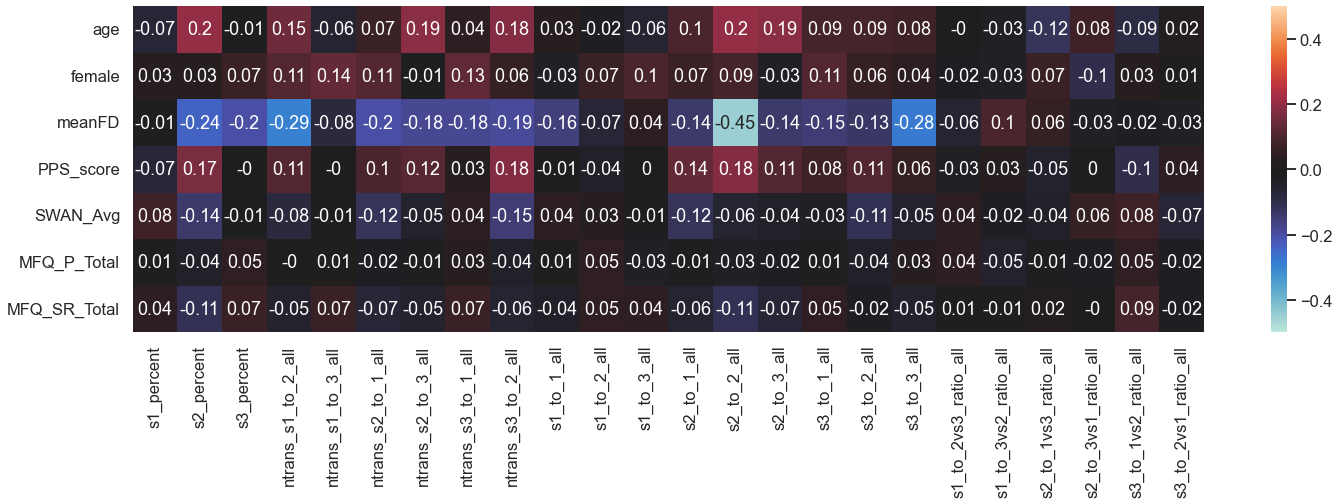

In [11]:
movie='DM'
full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
c = full_data.corr()
plt.figure(figsize=(24,6))
sns.heatmap(c.loc[['age', 'female', 'meanFD','PPS_score', 'SWAN_Avg','MFQ_P_Total','MFQ_SR_Total'],
                  ['s1_percent', 's2_percent', 's3_percent','ntrans_s1_to_2_all', 'ntrans_s1_to_3_all',
                   'ntrans_s2_to_1_all',  'ntrans_s2_to_3_all',
                   'ntrans_s3_to_1_all', 'ntrans_s3_to_2_all', 
                   's1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
                   's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
                   's3_to_3_all', 's1_to_2vs3_ratio_all', 's1_to_3vs2_ratio_all',
                   's2_to_1vs3_ratio_all', 's2_to_3vs1_ratio_all', 's3_to_1vs2_ratio_all',
                   's3_to_2vs1_ratio_all']].round(2), 
            center=0, vmax=0.5, vmin=-0.5, annot=True)

<AxesSubplot:>

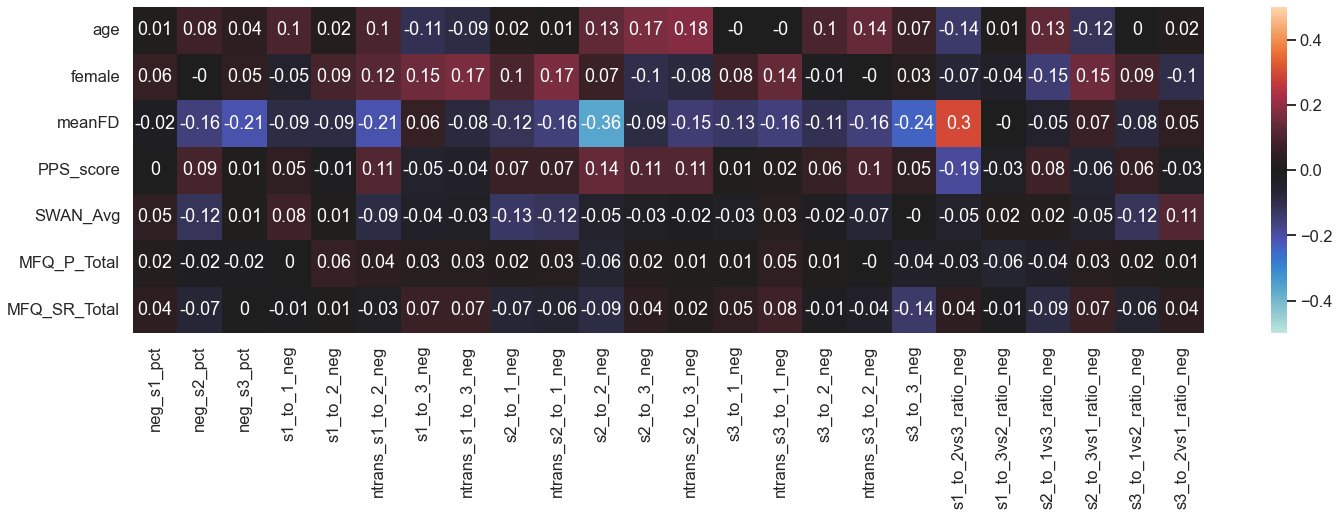

In [13]:
movie='DM'

full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
c = full_data.corr().round(2)
plt.figure(figsize=(24,6))
sns.heatmap(c.loc[['age', 'female', 'meanFD','PPS_score','SWAN_Avg','MFQ_P_Total','MFQ_SR_Total'],
                  ['neg_s1_pct', 'neg_s2_pct', 'neg_s3_pct','s1_to_1_neg',  's1_to_2_neg',
                   'ntrans_s1_to_2_neg', 's1_to_3_neg', 'ntrans_s1_to_3_neg',
                   's2_to_1_neg', 'ntrans_s2_to_1_neg', 's2_to_2_neg','s2_to_3_neg', 'ntrans_s2_to_3_neg',
                   's3_to_1_neg', 'ntrans_s3_to_1_neg', 's3_to_2_neg',
                   'ntrans_s3_to_2_neg', 's3_to_3_neg', 's1_to_2vs3_ratio_neg', 's1_to_3vs2_ratio_neg', 
                   's2_to_1vs3_ratio_neg','s2_to_3vs1_ratio_neg', 's3_to_1vs2_ratio_neg', 's3_to_2vs1_ratio_neg']], 
            center=0, vmax=0.5, vmin=-0.5, annot=True)

## Compare age and puberty associations (full data)

In [142]:
from sklearn.preprocessing import StandardScaler, PowerTransformer

vs = ['age',  'meanFD',  'PPS_score', 's0_percent', 's1_percent', 's2_percent', 's3_percent',  'SWAN_Avg',
      's0_to_1vs2_ratio_all', 's0_to_2vs1_ratio_all','s1_to_0vs2_ratio_all', 's1_to_2vs0_ratio_all', 's2_to_0vs1_ratio_all','s2_to_1vs0_ratio_all']

vois = ['s0_percent', 's1_percent', 's2_percent', 's3_percent', 's0_to_1vs2_ratio_all', 
        's0_to_2vs1_ratio_all','s1_to_0vs2_ratio_all', 's1_to_2vs0_ratio_all', 's2_to_0vs1_ratio_all','s2_to_1vs0_ratio_all']

results_df = pd.DataFrame()
i=0

for movie in ['DM','TP']:
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    
    for s in vois:
        results = smf.glm('{0} ~ age + female + meanFD'.format(s), data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'age_coeff'] = results.params['age']
        results_df.loc[i, 'age_stat'] = results.tvalues['age']
        results_df.loc[i, 'age_pval'] = results.pvalues['age']
        results_df.loc[i, 'age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
        results_df.loc[i, 'female_coeff'] = results.params['female']
        results_df.loc[i, 'female_stat'] = results.tvalues['female']
        results_df.loc[i, 'female_pval'] = results.pvalues['female']
        results_df.loc[i, 'female_ci'] = '[{0}, {1}]'.format(round(ci.loc['female',0],2),round(ci.loc['female',1],2))
        i = i + 1
results_df.to_csv(os.path.join(out_folder, 'movieBoth_full_dataset_age_sex_motion_analysis.csv'))

results_df = pd.DataFrame()
i=0

for movie in ['DM','TP']:
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    
    for s in vois:
        results = smf.glm('{0} ~ PPS_score + female + meanFD'.format(s), data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'PPS_score_coeff'] = results.params['PPS_score']
        results_df.loc[i, 'PPS_score_stat'] = results.tvalues['PPS_score']
        results_df.loc[i, 'PPS_score_pval'] = results.pvalues['PPS_score']
        results_df.loc[i, 'PPS_score_ci'] = '[{0}, {1}]'.format(round(ci.loc['PPS_score',0],2),round(ci.loc['PPS_score',1],2))
        results_df.loc[i, 'female_coeff'] = results.params['female']
        results_df.loc[i, 'female_stat'] = results.tvalues['female']
        results_df.loc[i, 'female_pval'] = results.pvalues['female']
        results_df.loc[i, 'female_ci'] = '[{0}, {1}]'.format(round(ci.loc['female',0],2),round(ci.loc['female',1],2))
        i = i + 1
results_df.to_csv(os.path.join(out_folder, 'movieBoth_full_dataset_puberty_sex_motion_analysis.csv'))

## Compare puberty and age (neg)

In [143]:
vs = ['age',  'meanFD',  'PPS_score', 'neg_s0_pct', 'neg_s1_pct', 'neg_s2_pct',  'neg_s3_pct', 'SWAN_Avg','s0_to_1vs2_ratio_neg',
      's0_to_2vs1_ratio_neg','s1_to_0vs2_ratio_neg', 's1_to_2vs0_ratio_neg', 's2_to_0vs1_ratio_neg','s2_to_1vs0_ratio_neg']
vois = ['s0_to_1vs2_ratio_neg','s0_to_2vs1_ratio_neg','s1_to_0vs2_ratio_neg', 's1_to_2vs0_ratio_neg', 
        's2_to_0vs1_ratio_neg','s2_to_1vs0_ratio_neg']

results_df = pd.DataFrame()
i=0
    
for movie in ['DM','TP']:
    for n in ['neg']:
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())

        for s in vois:
            results = smf.glm('{0} ~ age + female + meanFD'.format(s), data=full_data).fit()
            ci=results.conf_int()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'age_coeff'] = results.params['age']
            results_df.loc[i, 'age_stat'] = results.tvalues['age']
            results_df.loc[i, 'age_pval'] = results.pvalues['age']
            results_df.loc[i, 'age_ci'] = '[{0}, {1}]'.format(round(ci.loc['age',0],2),round(ci.loc['age',1],2))
            i = i + 1
    results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_dataset_age_analysis.csv'.format(movie)))

    results_df = pd.DataFrame()
    i=0

    for n in ['neg']:
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())

        for s in vois:
            results = smf.glm('{0} ~ PPS_score + female + meanFD'.format(s), data=full_data).fit()
            ci=results.conf_int()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'PPS_score_coeff'] = results.params['PPS_score']
            results_df.loc[i, 'PPS_score_stat'] = results.tvalues['PPS_score']
            results_df.loc[i, 'PPS_score_pval'] = results.pvalues['PPS_score']
            results_df.loc[i, 'PPS_score_ci'] = '[{0}, {1}]'.format(round(ci.loc['PPS_score',0],2),round(ci.loc['PPS_score',1],2))
            i = i + 1
    results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_dataset_puberty_analysis.csv'.format(movie)))

## look at state info during negative states

In [144]:
results_df = pd.DataFrame()
i=0
    
for movie in ['DM','TP']:
    for n in ['neg']:
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_full_dataset.csv'.format(movie)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())

        for s in vois:
            results = smf.glm('{0} ~ age + female + meanFD + SWAN_Avg'.format(s), data=full_data).fit()
            ci=results.conf_int()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'adhd_coeff'] = results.params['SWAN_Avg']
            results_df.loc[i, 'adhd_stat'] = results.tvalues['SWAN_Avg']
            results_df.loc[i, 'adhd_pval'] = results.pvalues['SWAN_Avg']
            results_df.loc[i, 'adhd_ci'] = '[{0}, {1}]'.format(round(ci.loc['SWAN_Avg',0],2),round(ci.loc['SWAN_Avg',1],2))
            results_df.loc[i, 'female_coeff'] = results.params['female']
            results_df.loc[i, 'female_stat'] = results.tvalues['female']
            results_df.loc[i, 'female_pval'] = results.pvalues['female']
            results_df.loc[i, 'female_ci'] = '[{0}, {1}]'.format(round(ci.loc['female',0],2),round(ci.loc['female',1],2))
            i = i + 1
    results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_dataset_adhd_sex_analysis.csv'.format(movie)))

# Anxiety

## Characterize overall associations

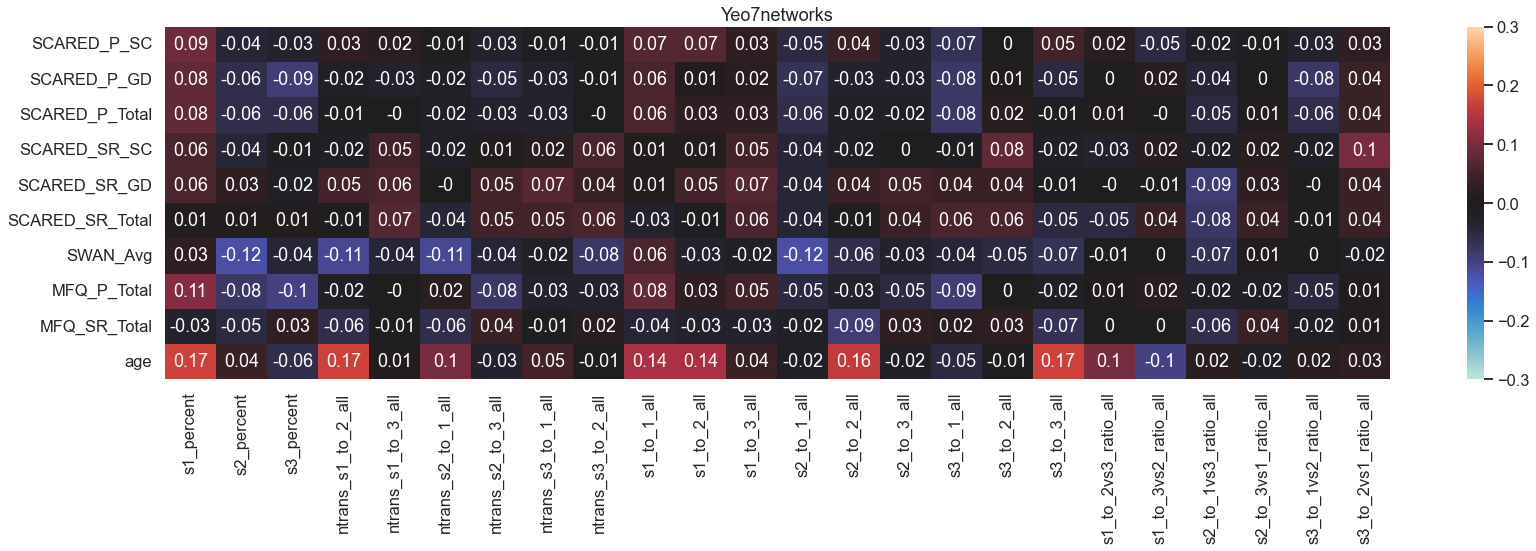

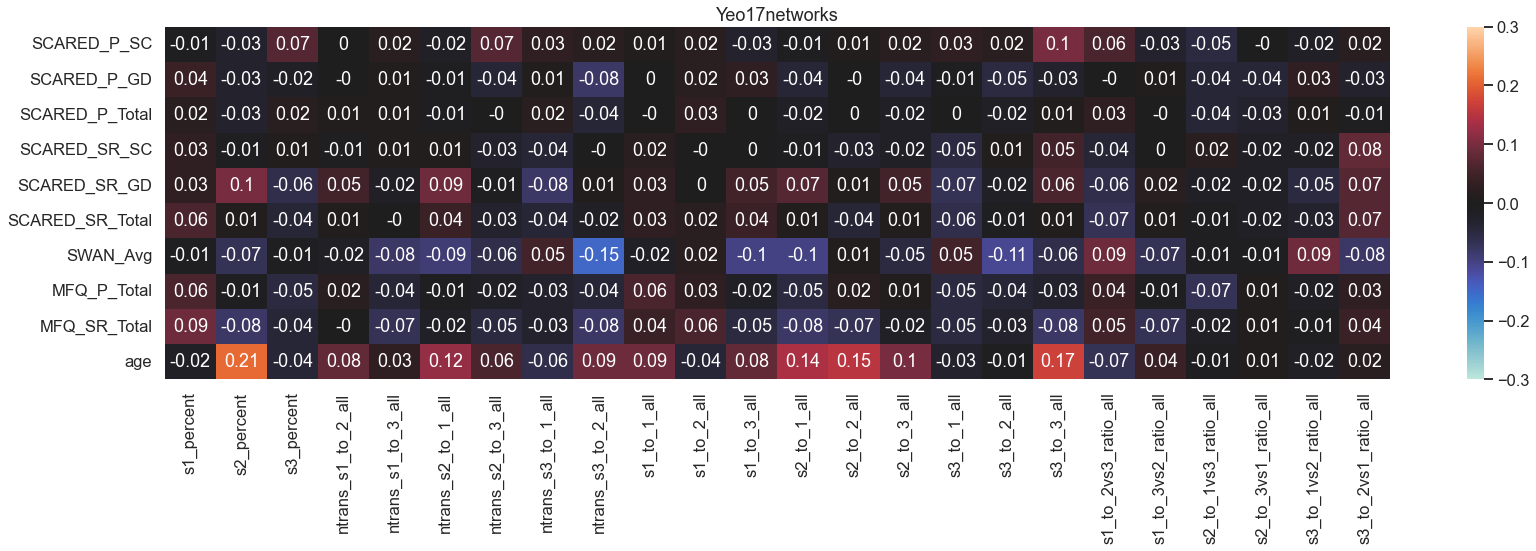

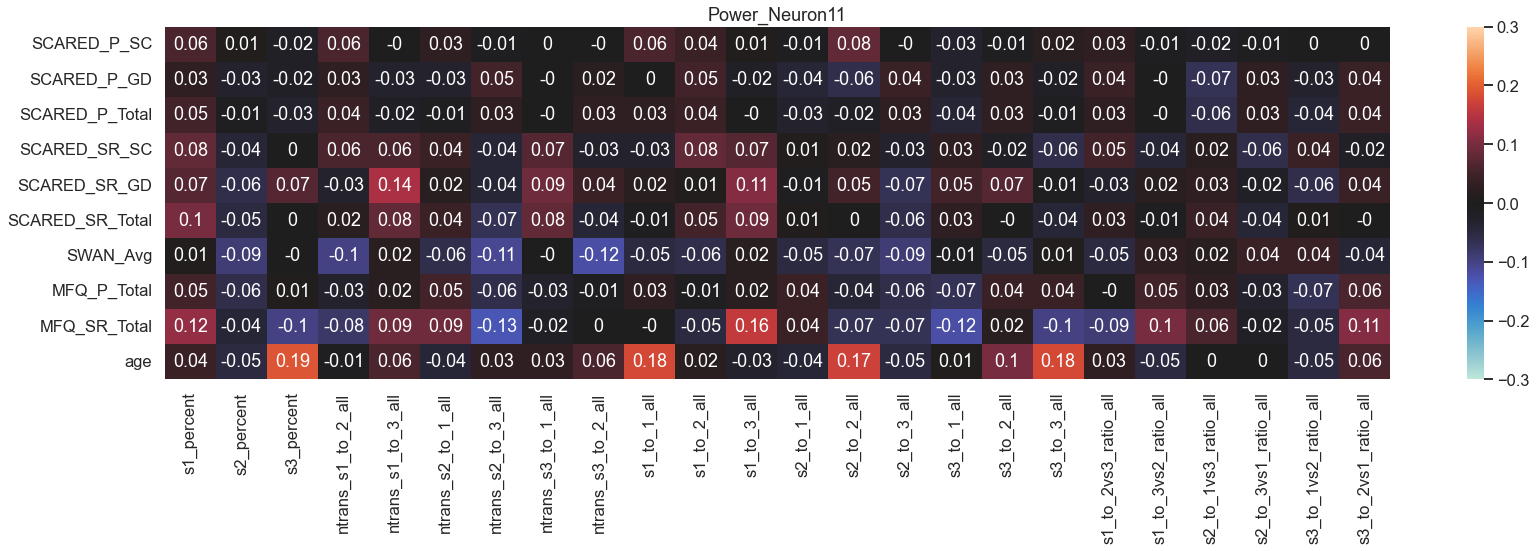

In [12]:
vois = ['s1_percent', 's2_percent', 's3_percent','ntrans_s1_to_2_all', 'ntrans_s1_to_3_all',
                   'ntrans_s2_to_1_all',  'ntrans_s2_to_3_all',
                   'ntrans_s3_to_1_all', 'ntrans_s3_to_2_all', 
                   's1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
                   's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
                   's3_to_3_all', 's1_to_2vs3_ratio_all', 's1_to_3vs2_ratio_all',
                   's2_to_1vs3_ratio_all', 's2_to_3vs1_ratio_all', 's3_to_1vs2_ratio_all',
                   's3_to_2vs1_ratio_all']
sxs = ['SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
                       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total', 
                       'SWAN_Avg', 'MFQ_P_Total','MFQ_SR_Total','age']

for atlas in atlasnames:
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_{1}_full_dataset.csv'.format(movie, atlas)), index_col=0)
    c = full_data.loc[:,sxs+vois].corr().round(2)
    plt.figure(figsize=(24,8))
    sns.heatmap(c.loc[sxs, vois],center=0, vmax=0.3, vmin=-0.3, annot=True)
    plt.title(atlas)
    plt.tight_layout()
    plt.show()
    plt.close()

In [13]:
pct = ['s1_percent', 's2_percent', 's3_percent']
trans = ['ntrans_s1_to_2_all', 'ntrans_s1_to_3_all','ntrans_s2_to_1_all',  
         'ntrans_s2_to_3_all','ntrans_s3_to_1_all', 'ntrans_s3_to_2_all']
odds = ['s1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
        's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
        's3_to_3_all']
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg'] + pct + trans + odds
cs = ['SCARED_SR_GD', 'SCARED_SR_SC', 'SCARED_SR_Total', 'MFQ_SR_Total']
movie='DM'

for atlas in atlasnames:
    results_df = pd.DataFrame()
    
    i=0
    for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
        start = i
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_{1}_full_dataset.csv'.format(movie, atlas)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
        full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
        
        for s in pct:
            results = smf.glm('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        rej, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
        
        start = i
        for s in trans:
            results = smf.glm('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
    
        start = i
        for s in odds:
            results = smf.glm('{0} ~ {1} + age + female + meanFD'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
    results_df.to_csv(os.path.join(out_folder, 'movieDM_full_anx_analysis_results_{0}.csv'.format(atlas)))

In [14]:
pct = ['s1_percent', 's2_percent', 's3_percent']
trans = ['ntrans_s1_to_2_all', 'ntrans_s1_to_3_all','ntrans_s2_to_1_all',  
         'ntrans_s2_to_3_all','ntrans_s3_to_1_all', 'ntrans_s3_to_2_all']
odds = ['s1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
        's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
        's3_to_3_all']
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg'] + pct + trans + odds
cs = ['SCARED_SR_GD', 'SCARED_SR_SC', 'SCARED_SR_Total', 'MFQ_SR_Total']
movie='DM'

for atlas in atlasnames:
    results_df = pd.DataFrame()
    
    i=0
    for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
        start = i
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_{1}_full_dataset.csv'.format(movie, atlas)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
        full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
        
        for s in pct:
            results = smf.glm('{0} ~ {1} + age + female + meanFD + SWAN_Avg'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        rej, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
        
        start = i
        for s in trans:
            results = smf.glm('{0} ~ {1} + age + female + meanFD + SWAN_Avg'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
    
        start = i
        for s in odds:
            results = smf.glm('{0} ~ {1} + age + female + meanFD + SWAN_Avg'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
    results_df.to_csv(os.path.join(out_folder, 'movieDM_full_anx_analysis_results_covADHD_{0}.csv'.format(atlas)))

In [15]:
pct = ['s1_percent', 's2_percent', 's3_percent']
trans = ['ntrans_s1_to_2_all', 'ntrans_s1_to_3_all','ntrans_s2_to_1_all',  
         'ntrans_s2_to_3_all','ntrans_s3_to_1_all', 'ntrans_s3_to_2_all']
odds = ['s1_to_1_all', 's1_to_2_all', 's1_to_3_all', 's2_to_1_all',
        's2_to_2_all', 's2_to_3_all', 's3_to_1_all', 's3_to_2_all',
        's3_to_3_all']
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg'] + pct + trans + odds
cs = ['SCARED_SR_GD', 'SCARED_SR_SC', 'SCARED_SR_Total', 'MFQ_SR_Total']
movie='DM'

for atlas in atlasnames:
    results_df = pd.DataFrame()
    
    i=0
    for c in ['SCARED_SR_GD', 'SCARED_SR_SC']:
        start = i
        full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_{1}_full_dataset.csv'.format(movie, atlas)), index_col=0)
        full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
        full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
        
        for s in pct:
            results = smf.glm('{0} ~ {1} + age + female + meanFD + MFQ_SR_Total'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        rej, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
        
        start = i
        for s in trans:
            results = smf.glm('{0} ~ {1} + age + female + meanFD + MFQ_SR_Total'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
    
        start = i
        for s in odds:
            results = smf.glm('{0} ~ {1} + age + female + meanFD + MFQ_SR_Total'.format(s, c), data=full_data).fit()
            results_df.loc[i, 'movie'] = movie
            results_df.loc[i, 'DV'] = s
            results_df.loc[i, 'IV'] = c
            results_df.loc[i, 'IV_coeff'] = results.params[c]
            results_df.loc[i, 'IV_stat'] = results.tvalues[c]
            results_df.loc[i, 'IV_pval'] = results.pvalues[c]
            ci=results.conf_int()
            results_df.loc[i, 'IV_ci'] = '[{0}, {1}]'.format(round(ci.loc[c,0],2),round(ci.loc[c,1],2))
            results_df.loc[i, 'FDRp'] = np.nan
            i = i + 1
        _, fdr_p = fdrcorrection(results_df['IV_pval'][start:i])
        results_df.iloc[start:i, -1] = fdr_p
    results_df.to_csv(os.path.join(out_folder, 'movieDM_full_anx_analysis_results_covMFQ_{0}.csv'.format(atlas)))

## look at state info during negative emotion processing

In [16]:
vs = ['age',  'meanFD',  'PPS_score','SWAN_Avg', 'neg_s1_pct',
       'nonneg_s1_pct', 'neg_s1_prob', 'nonneg_s1_prob', 'neg_s2_pct',
       'nonneg_s2_pct', 'neg_s2_prob', 'nonneg_s2_prob', 'neg_s3_pct',
       'nonneg_s3_pct', 'neg_s3_prob', 'nonneg_s3_prob']

cs = ['SCARED_P_SC', 'SCARED_P_GD', 'SCARED_P_Total',
       'SCARED_SR_SC', 'SCARED_SR_GD', 'SCARED_SR_Total']

vois_neg_pct = ['neg_s1_pct','neg_s2_pct', 'neg_s3_pct']

vois_nonneg_pct = ['nonneg_s1_pct', 'nonneg_s2_pct', 'nonneg_s3_pct']

vois_txodds = ['s1_to_1_neg', 's1_to_2_neg', 's1_to_3_neg',
               's2_to_1_neg', 's2_to_2_neg', 's2_to_3_neg', 
               's3_to_1_neg', 's3_to_2_neg', 's3_to_3_neg']

vois_trans = ['ntrans_s1_to_2_neg','ntrans_s1_to_3_neg','ntrans_s2_to_1_neg',
              'ntrans_s2_to_3_neg','ntrans_s3_to_1_neg','ntrans_s3_to_2_neg']


movie='DM'

for atlas in atlasnames:
    results_df = pd.DataFrame()
    i=0
    
    full_data = pd.read_csv(os.path.join(out_folder, 'movie{0}_{1}_full_dataset.csv'.format(movie, atlas)), index_col=0)
    full_data.loc[:,vs] = StandardScaler().fit_transform(full_data.loc[:,vs].to_numpy())
    full_data.loc[:,cs] = PowerTransformer().fit_transform(full_data.loc[:,cs].to_numpy())
    
    # time spent in each state
    for s in vois_neg_pct:
        results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                          data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
        results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
        i = i + 1
    
    from statsmodels.stats.multitest import fdrcorrection
    rej, fdr_p = fdrcorrection(results_df['GD_pval'])
    results_df.loc[:, 'GD_FDRp'] = fdr_p
    
    ## transition probabilities
    start = i
    for s in vois_nonneg_pct:
        results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                          data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
        results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
        i = i + 1
    
    # fdr correction
    from statsmodels.stats.multitest import fdrcorrection
    rej, fdr_p = fdrcorrection(results_df['GD_pval'][start:i])
    results_df.loc[start:i, 'GD_FDRp'] = fdr_p
    
    ## transition counts
    start = i
    for s in vois_txodds:
        results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                          data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
        results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
        i = i + 1
    
    # fdr correction
    from statsmodels.stats.multitest import fdrcorrection
    rej, fdr_p = fdrcorrection(results_df['GD_pval'][start:i])
    results_df.loc[start:, 'GD_FDRp'] = fdr_p
    
    ## transition odds
    start = i
    for s in vois_trans:
        results = smf.glm('{0} ~ SCARED_SR_GD + age + female + meanFD'.format(s), 
                          data=full_data).fit()
        ci=results.conf_int()
        results_df.loc[i, 'movie'] = movie
        results_df.loc[i, 'DV'] = s
        results_df.loc[i, 'GD_coeff'] = results.params['SCARED_SR_GD']
        results_df.loc[i, 'GD_stat'] = results.tvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_pval'] = results.pvalues['SCARED_SR_GD']
        results_df.loc[i, 'GD_ci'] = '[{0}, {1}]'.format(round(ci.loc['SCARED_SR_GD',0],2),round(ci.loc['SCARED_SR_GD',1],2))
        i = i + 1
    
    # fdr correction
    from statsmodels.stats.multitest import fdrcorrection
    rej, fdr_p = fdrcorrection(results_df['GD_pval'][start:i])
    results_df.loc[start:, 'GD_FDRp'] = fdr_p
    
    results_df.to_csv(os.path.join(out_folder, 'movie{0}_neg_GD_sanalysis_results_{1}.csv'.format(movie, atlas)))